In [1]:
# Import relevant modules
import cv2
import numpy as np
from matplotlib import pyplot as plt
from helper_functions.utils import *

TRAIN_IMGS_DIR = "../data/train"

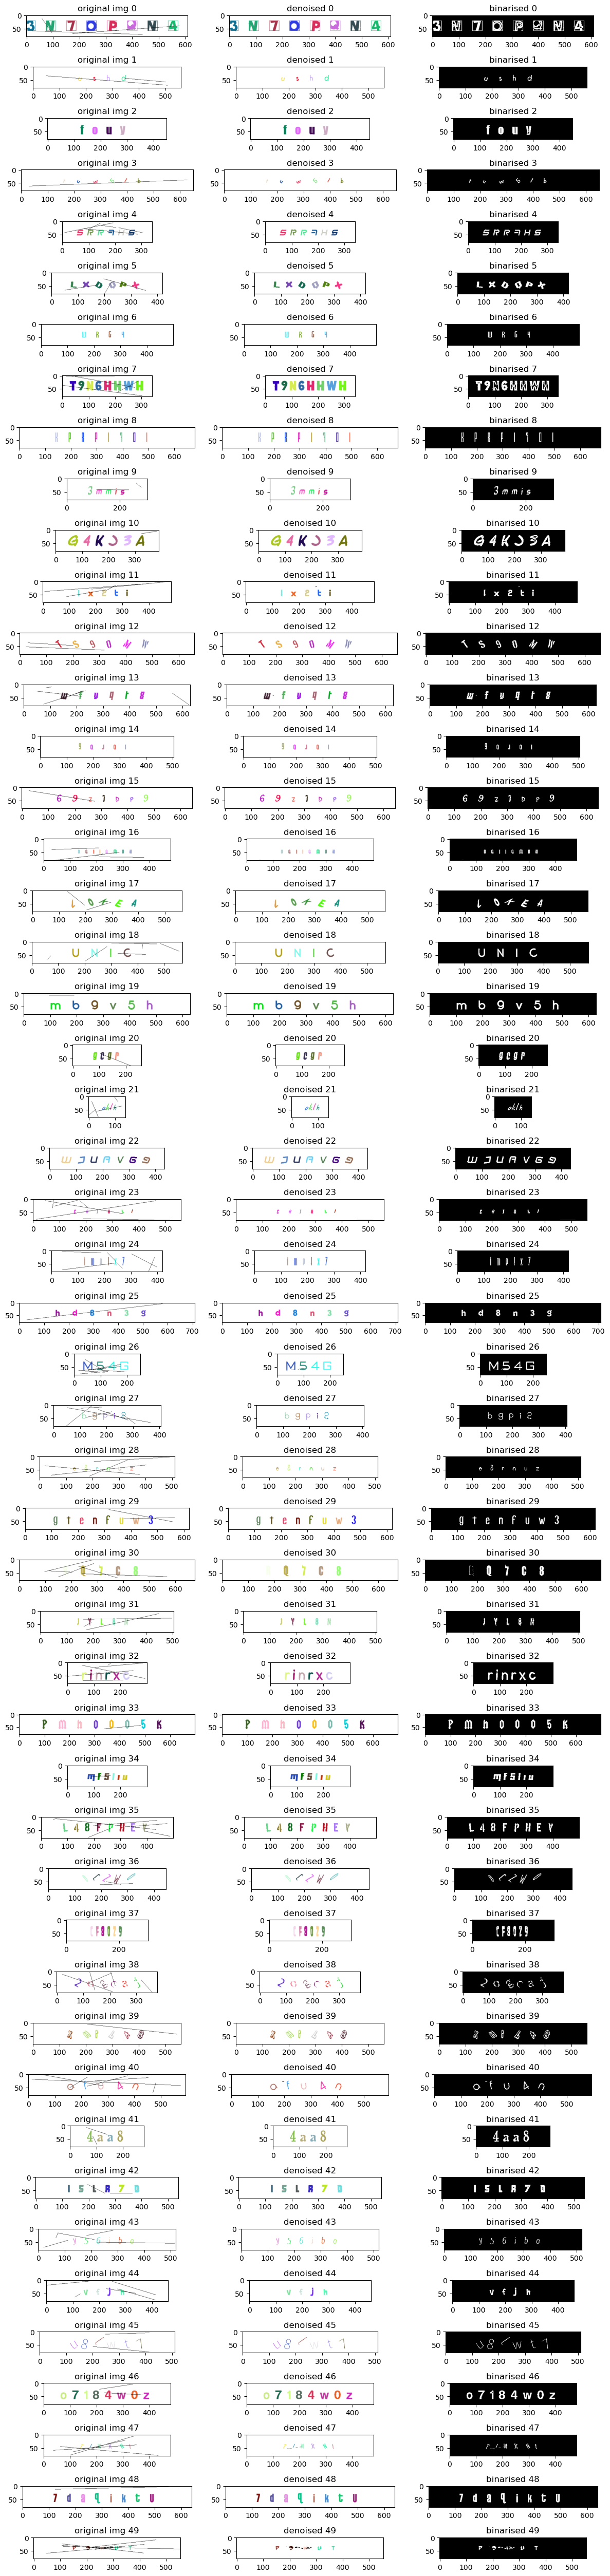

In [2]:
from helper_functions.preprocessing import replace_black_with_median, binarization_max_contrast

"""
Prep some binarised images first before segmentation
"""
NUM_IMGS = 50
imgs = get_n_random_train_imgs(TRAIN_IMGS_DIR, NUM_IMGS)
denoised_imgs = [replace_black_with_median(img.copy()) for img in imgs]

# Apply thresholding to binarize the image
gray_denoised_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in denoised_imgs]

binarised_imgs = [binarization_max_contrast(img) for img in denoised_imgs]

fig, axes = plt.subplots(nrows=NUM_IMGS, ncols=3, figsize=(12, NUM_IMGS))
for i in range(NUM_IMGS):
    imshow_bulk(imgs[i], f"original img {i}", axes[i,0])
    imshow_bulk(denoised_imgs[i], f"denoised {i}", axes[i,1])
    imshow_bulk(binarised_imgs[i], f"binarised {i}", axes[i,2])
plt.tight_layout()
plt.show()



In [3]:
"""
Connected Component Analysis (CCA)
"""
# # Find connected components
# contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# char_images = []
# for cnt in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     char_images.append(binary[y:y+h, x:x+w])  # Crop character

# # Sort by x-coordinates to maintain reading order
# char_images = sorted(char_images, key=lambda im: im.shape[1])

# # Display segmented characters
# for i, char in enumerate(char_images):
#     plt.subplot(21, len(char_images), i+2)
#     plt.imshow(char, cmap='gray')
#     plt.axis('off')


'\nConnected Component Analysis (CCA)\n'

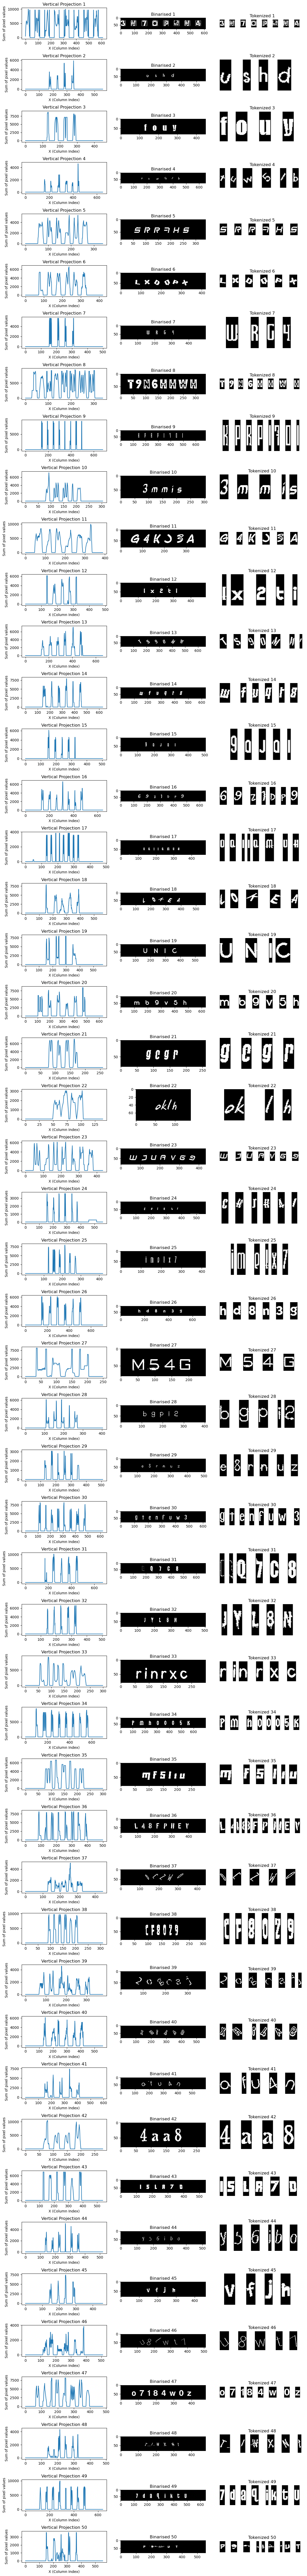

In [4]:
"""
Vertical Projection (to get the horizontal segments of characters)
"""
# Compute vertical projection (sum of pixel values along columns)
vertical_projs = [np.sum(binary, axis=0) for binary in binarised_imgs]

# Identify gap points (valleys where projection value is low), then derive horizontal segments of characters
thresholds = [np.max(vertical_proj) * 0.05 for vertical_proj in vertical_projs] # Adjust threshold as needed
all_x_gap_points = [np.where(vertical_proj < threshold)[0] for vertical_proj, threshold in zip(vertical_projs, thresholds)]
all_x_segments = []
for x_gap_points in all_x_gap_points:
    x_segments = []
    prev = 0
    for point in x_gap_points:
        if point - prev > 2:  # Adjust spacing threshold
            x_segments.append((prev, point))
        prev = point
    all_x_segments.append(x_segments)

# Compute horizontal projection (sum of pixel values along rows) to trim the vertical axis
horizontal_projs = [np.sum(binary, axis=1) for binary in binarised_imgs]
# Find min_y and max_y for each image
all_y_bounds = []
for horizontal_proj in horizontal_projs:
    nonzero_indices = np.where(horizontal_proj > 0)[0]  # Find rows containing characters
    if nonzero_indices.size > 0:
        min_y, max_y = max(0,nonzero_indices[0]-10), nonzero_indices[-1]+10
    else:
        min_y, max_y = 0, horizontal_proj.shape[0] - 1  # If the image is empty, keep full height
    all_y_bounds.append((min_y, max_y))


# Extract individual characters using bounding boxes
all_char_images = []
i = 0
for x_segments, binary, y_bounds in zip(all_x_segments, binarised_imgs, all_y_bounds):
    char_images = []
    for start,end in x_segments:
        char_images.append(binary[y_bounds[0]:y_bounds[1]+1, start:end+1])
    # Remove any noise (> 95% zeros)
    char_images = [char for char in char_images if not np.count_nonzero(char == 0) / char.size > 0.95]

    all_char_images.append(char_images)
    i += 1



# Create a figure
fig, axes = plt.subplots(NUM_IMGS, 3, figsize=(12, 2 * NUM_IMGS))

# Loop over each image
for i in range(NUM_IMGS):
    # Plot vertical projection in the first column
    ax1 = axes[i, 0]  # First column
    ax1.plot(vertical_projs[i])  # Plot the vertical projection
    ax1.set_title(f"Vertical Projection {i + 1}")
    ax1.set_xlabel("X (Column Index)")
    ax1.set_ylabel("Sum of pixel values")

    # Plot binarised image in the second column
    ax2 = axes[i, 1]  # Second column
    imshow_bulk(binarised_imgs[i], f"Binarised {i + 1}", ax2)

    # Plot tokenized characters in the third column
    ax3 = axes[i, 2]  # Third column
    tokenized_imgs = all_char_images[i]
    
    # Create a list to hold the images with spacing
    tokenized_with_spacing = []
    for char_img in tokenized_imgs:
        tokenized_with_spacing.append(char_img)  # Add the character image
        # Add a white image for spacing
        blank_image = np.ones_like(char_img) * 255
        tokenized_with_spacing.append(blank_image)
    
    # Combine tokenized characters with spacing
    if tokenized_with_spacing:
        combined_img = np.hstack(tokenized_with_spacing)
        
        ax3.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
        ax3.set_title(f"Tokenized {i + 1}")
        ax3.axis('off')  # Turn off axes for a cleaner display

plt.tight_layout()
plt.show()

In [5]:
"""
Improvement to vertical projection: Try normalising the vertical projection graph, and segment based on peak-trough instead of using a fixed threshold
"""
# from scipy.signal import find_peaks

# def find_segmentation_points(projection, min_dist=30, max_dist=50):
#     """
#     Find segmentation points (troughs) in the vertical projection.

#     Rules:
#     - A trough must be at least `min_dist` away from the last peak.
#     - If a trough isn't found within `max_dist` from the last one, force the next trough.

#     Args:
#     - projection: 1D numpy array of vertical projection values.
#     - min_dist: Minimum distance required between a peak and a trough.
#     - max_dist: Maximum distance before forcing a trough.

#     Returns:
#     - seg_points: List of x-coordinates for character segmentation.
#     """
#     # Normalize projection for consistency
#     projection = projection / np.max(projection)

#     # Find peaks (characters) and troughs (spaces between characters)
#     peaks, _ = find_peaks(projection, distance=min_dist)
#     troughs, _ = find_peaks(-projection, distance=min_dist)

#     # Apply rules
#     filtered_troughs = []
#     last_peak = None
#     last_trough = None

#     for trough in troughs:
#         # Rule 1: Ensure minimum distance from last peak
#         if last_peak is not None and (trough - last_peak) < min_dist:
#             continue  # Skip this trough
        
#         # Rule 2: Ensure we don’t go too far without a trough
#         if last_trough is not None and (trough - last_trough) > max_dist:
#             filtered_troughs.append(trough)  # Force segmentation at the first available trough
        
#         # Store the last confirmed peak and trough
#         filtered_troughs.append(trough)
#         last_trough = trough

#         # Find the nearest peak before this trough
#         possible_peaks = peaks[peaks < trough]
#         if len(possible_peaks) > 0:
#             last_peak = possible_peaks[-1]  # Last peak before this trough

#     return filtered_troughs

# # Compute vertical projection (sum of pixel values along columns)
# vertical_projs = [np.sum(binary, axis=0) for binary in binarised_imgs]

# # Plot settings
# fig, axes = plt.subplots(NUM_IMGS, 1, figsize=(8, NUM_IMGS * 3))

# for i in range(NUM_IMGS):
#     vertical_proj = vertical_projs[i]
#     seg_points = find_segmentation_points(vertical_proj, min_dist=5, max_dist=30)

#     # Plot vertical projection
#     axes[i].plot(vertical_proj, color='blue', label=f"Image {i+1} Projection")
#     axes[i].scatter(seg_points, vertical_proj[seg_points], color='red', marker='x', label="Segmentation Points")
#     axes[i].legend()
#     axes[i].set_ylabel("Intensity")
#     axes[i].set_xlabel("X (Column Index)")


# plt.suptitle("Vertical Projection Segmentation Across 10 Images", fontsize=14)
# plt.tight_layout()
# plt.show()




'\nImprovement to vertical projection: Try normalising the vertical projection graph, and segment based on peak-trough instead of using a fixed threshold\n'